In [17]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings ('ignore')
%matplotlib inline

In [18]:
df = pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)
df = pd.read_csv ("sample_data.csv")
df


,ProductID,ProductName,Category,Price,Rating,ReviewCount,Stock,Discount,Brand,LaunchDate
0,101,Wireless Mouse,Electronics,25.99,4.5,200,150,10%,Logitech,15-01-2022
1,102,Gaming Keyboard,Electronics,75.49,4.7,350,85,5%,Corsair,20-11-2021
2,103,Noise Cancelling Headphones,Electronics,199.99,4.8,125,60,15%,Sony,05-09-2021
3,104,Running Shoes,Sports,49.99,4.3,500,200,20%,Nike,10-02-2022
4,105,Smartwatch,Electronics,159.99,4.6,220,45,10%,Apple,30-03-2022
5,106,Blender,Home & Kitchen,39.99,4.2,180,120,12%,Ninja,25-12-2021
6,107,Coffee Maker,Home & Kitchen,89.99,4.1,240,90,8%,Keurig,15-08-2021
7,108,Yoga Mat,Sports,29.99,4.4,320,300,5%,Manduka,05-01-2022
8,109,Smart TV,Electronics,399.99,4.7,150,25,15%,Samsung,10-06-2022
9,110,Vacuum Cleaner,Home & Kitchen,129.99,4.3,290,70,10%,Dyson,20-10-2021


## Code for Loading CSV into MongoDB:

In [19]:
from pymongo import MongoClient

# Establish MongoDB connection (assuming MongoDB is running locally on default port)
client = MongoClient('mongodb://localhost:27017/')
db = client['product_db']  # Create or access the 'product_db' database
collection = db['products']  # Create or access the 'products' collection

# Convert the 'LaunchDate' to a standard date format and convert the discount to numeric
df['LaunchDate'] = pd.to_datetime(df['LaunchDate'], format='%d-%m-%Y', errors='coerce')
#df['Discount'] = df['Discount'].str.rstrip('%').astype('float')
df['Discount'] = df['Discount'].astype(str).str.rstrip('%').astype(float)


# Insert the data into MongoDB
collection.delete_many({})  # Clear any existing data in the collection for a fresh insert
collection.insert_many(df.to_dict(orient='records'))

# Check if the data was inserted successfully
collection.count_documents({})  # Returns the number of documents in the collection
print(f"Inserted {collection.count_documents({})} documents into MongoDB.")

Inserted 10 documents into MongoDB.


## Generating MongoDB Queries Based on Test Cases:


### test case 1 : Find products with a rating below 4.5, more than 200 reviews, and from 'Nike' or 'Sony'.

In [20]:
query = {"Rating": {"$lt": 4.5}, "ReviewCount": {"$gt": 200}, "Brand": {"$in": ["Nike", "Sony"]}}

### test case 2 :Find products in the 'Electronics' category with a rating of 4.5 or higher and in stock.

In [21]:
query = {"Category": "Electronics", "Rating": {"$gte": 4.5}, "Stock": {"$gt": 0}}

### test case 3:  List products launched after January 1, 2022, in 'Home & Kitchen' or 'Sports' with a discount of 10% or more, sorted by price (descending).

In [22]:
query = {"LaunchDate": {"$gt": pd.Timestamp('2022-01-01')}, 
         "Category": {"$in": ["Home & Kitchen", "Sports"]}, 
         "Discount": {"$gte": 10}}
sort_criteria = [("Price", -1)]  # Sort by price in descending order


### Retrieving and Saving Data from MongoDB:

In [23]:
import csv

def retrieve_data(query, collection, sort=None, output_file=None):
    result = collection.find(query).sort(sort) if sort else collection.find(query)
    data = list(result)
    
    if output_file:
        # Save to CSV
        keys = data[0].keys()
        with open(output_file, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=keys)
            writer.writeheader()
            writer.writerows(data)
        print(f"Data saved to {output_file}")
    else:
        for item in data:
            print(item)

# Test Case 1
query_1 = {"Rating": {"$lt": 4.5}, "ReviewCount": {"$gt": 200}, "Brand": {"$in": ["Nike", "Sony"]}}
retrieve_data(query_1, collection, output_file="test_case1.csv")

# Test Case 2
query_2 = {"Category": "Electronics", "Rating": {"$gte": 4.5}, "Stock": {"$gt": 0}}
retrieve_data(query_2, collection, output_file="test_case2.csv")

# Test Case 3
query_3 = {"LaunchDate": {"$gt": pd.Timestamp('2022-01-01')}, "Category": {"$in": ["Home & Kitchen", "Sports"]}, "Discount": {"$gte": 10}}
retrieve_data(query_3, collection, sort=[("Price", -1)], output_file="test_case3.csv")


Data saved to test_case1.csv
Data saved to test_case2.csv
Data saved to test_case3.csv


## Visualizing MongoDB Data Using Python

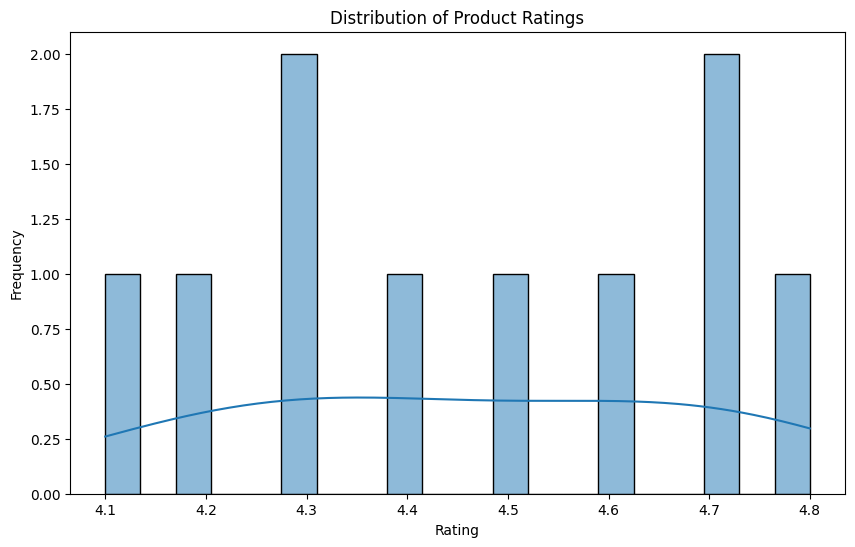

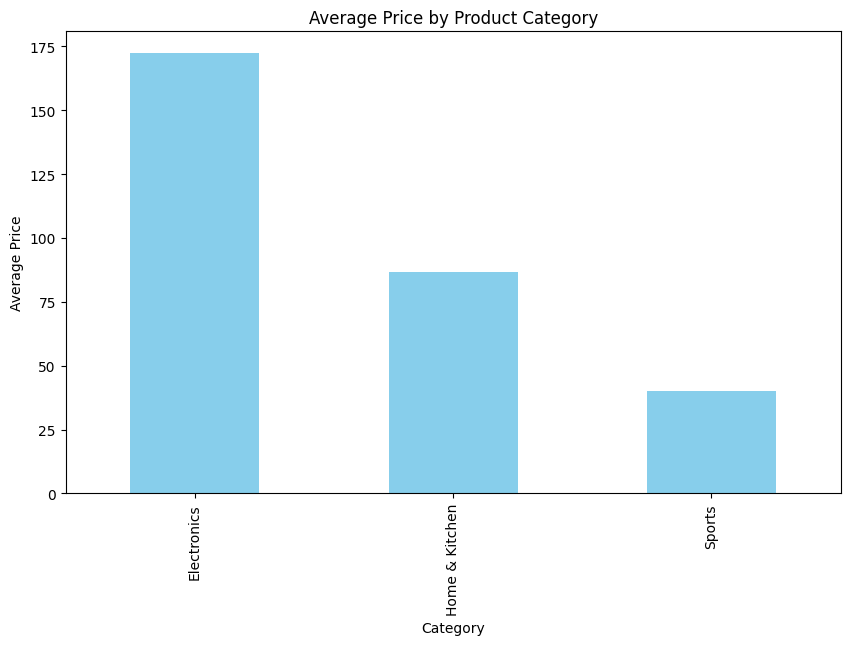

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['product_db']
collection = db['products']

# Query MongoDB and load data into a Pandas DataFrame
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

# Example 1: Visualize the distribution of product ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Example 2: Bar plot for average price by category
plt.figure(figsize=(10, 6))
avg_price_by_category = df.groupby('Category')['Price'].mean()
avg_price_by_category.plot(kind='bar', color='skyblue')
plt.title('Average Price by Product Category')
plt.xlabel('Category')
plt.ylabel('Average Price')
plt.show()

### Python based CLI


In [25]:
import pandas as pd
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['product_db']
collection = db['products']

def generate_mongo_query(column, condition, value):
    """Generates a MongoDB query based on the user input."""
    # For numerical comparisons
    if condition == "greater than":
        query = {column: {"$gt": float(value)}}
    elif condition == "less than":
        query = {column: {"$lt": float(value)}}
    elif condition == "equal to":
        query = {column: {"$eq": value}}
    
    # For string-based matches
    elif condition == "matches":
        query = {column: value}
    
    # Add more conditions as needed
    else:
        query = {}
    
    return query

def retrieve_data(query):
    """Retrieve data from MongoDB based on the generated query."""
    result = collection.find(query)
    return list(result)

def display_data(data):
    """Display data in a readable format."""
    for document in data:
        print(document)

def user_interface():
    """Command-line interface for querying MongoDB."""
    print("Welcome to the Product Query System")
    
    # Get the column name
    column = input("Enter the column name you want to query: ")
    
    # Get the condition
    condition = input("Enter the condition (greater than, less than, equal to, matches): ")
    
    # Get the value for the condition
    value = input("Enter the value to compare against: ")
    
    # Generate MongoDB query
    query = generate_mongo_query(column, condition, value)
    print(f"Generated Query: {query}")
    
    # Retrieve data based on the query
    data = retrieve_data(query)
    
    # Display data
    if data:
        display_data(data)
    else:
        print("No matching records found.")

# Run the interface
if __name__ == "__main__":
    user_interface()


Welcome to the Product Query System
Enter the column name you want to query: 50
Enter the condition (greater than, less than, equal to, matches): 50
Enter the value to compare against: 50
Generated Query: {}
{'_id': ObjectId('66ec77099017aa2bfe2a7863'), 'ProductID': 101, 'ProductName': 'Wireless Mouse', 'Category': 'Electronics', 'Price': 25.99, 'Rating': 4.5, 'ReviewCount': 200, 'Stock': 150, 'Discount': 10.0, 'Brand': 'Logitech', 'LaunchDate': datetime.datetime(2022, 1, 15, 0, 0)}
{'_id': ObjectId('66ec77099017aa2bfe2a7864'), 'ProductID': 102, 'ProductName': 'Gaming Keyboard', 'Category': 'Electronics', 'Price': 75.49, 'Rating': 4.7, 'ReviewCount': 350, 'Stock': 85, 'Discount': 5.0, 'Brand': 'Corsair', 'LaunchDate': datetime.datetime(2021, 11, 20, 0, 0)}
{'_id': ObjectId('66ec77099017aa2bfe2a7865'), 'ProductID': 103, 'ProductName': 'Noise Cancelling Headphones', 'Category': 'Electronics', 'Price': 199.99, 'Rating': 4.8, 'ReviewCount': 125, 'Stock': 60, 'Discount': 15.0, 'Brand': 'Son

### Table form

In [26]:
import pandas as pd

def display_data(data):
    """Display data in a tabular format using Pandas."""
    if data:
        df = pd.DataFrame(data)
        # Drop MongoDB internal ID if not needed
        if '_id' in df.columns:
            df.drop('_id', axis=1, inplace=True)
        print(df.to_string(index=False))
    else:
        print("No matching records found.")


### Pretty table

In [27]:
from prettytable import PrettyTable

def display_data(data):
    """Display data in a human-readable table format using PrettyTable."""
    if data:
        # Get the field names (keys of the first document)
        if len(data) > 0:
            headers = data[0].keys()
        else:
            headers = []

        # Initialize PrettyTable with headers
        table = PrettyTable(headers)
        
        # Add rows to the table
        for document in data:
            row = [document.get(header, '') for header in headers]
            table.add_row(row)
        
        # Print the table
        print(table)
    else:
        print("No matching records found.")
